<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/Module_9_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9 - Transfer Learning
# Student - Ravindra Sadaphule

One of the major benefits of transfer learning is transferring learned feature extraction to the
new model so that model training can start from a learned state, be faster, and sometimes
better than the original. Let us try to show if this really works by an experiment.
1. [20 pts] Using full MNIST dataset provided in the course, filter half of the digits grouped by
labels from the training dataset. The filtered subset dataset should only contain five of the
original ten labels. Pick the set of labels in such a way that if a feature to be extracted from
the data points of that label it will be compensated by another label. For example, label 3
and label 8 might have similar features. Another example could be label 0 and label 9.
2. [30 pts] Pick and train a model with half of the training dataset created in question (1.).
Report its testing performance on the MNIST testing dataset. Use a previously working
model in your experience. Especially a convolutional network would be very helpful.
3. [30 pts] Use the first model to train a second model while fixing the feature extraction. Use
the entire training dataset this time. Report model performance on the full testing dataset.
Now train a third model and do not fix the feature extraction, and report its performance.
Compare these performances.
4. [20 pts] Discuss the outcome you observed in (3.). Did the transfer learning work?


In [32]:
# Check if CUDA is available and set the device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Step 1: Creating a Subset of the MNIST Dataset
First, we'll load the MNIST dataset and create a subset containing only the digits 0, 2, 3, 7, and 9.

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the subset of labels we want to keep
subset_labels = [0, 2, 3, 7, 9]

# Filter the training dataset to only include the specified labels
subset_indices = [i for i, (image, label) in enumerate(train_dataset) if label in subset_labels]

# Create a subset of the training dataset
subset_train_dataset = Subset(train_dataset, subset_indices)

# Create data loaders
train_loader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 128826256.38it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38726244.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79786472.04it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4662390.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Step 2: Training the First Model
Now we'll define and train a RESNET CNN model on the subset of the MNIST dataset.

In [16]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# MNIST images are 1 channel (grayscale), ResNet expects 3 channels (RGB)
# We will modify the first convolutional layer to accept 1 channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training function
# Training function
# Training function that records the loss
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Record the loss
        train_losses.append(loss.item())

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



# Training loop
train_losses = []
for epoch in range(1, 30):
    train(model, device, train_loader, optimizer, epoch, train_losses)

Train Epoch: 1 [0/30226 (0%)]	Loss: 2.415155
Train Epoch: 1 [640/30226 (2%)]	Loss: 0.284568
Train Epoch: 1 [1280/30226 (4%)]	Loss: 0.214523
Train Epoch: 1 [1920/30226 (6%)]	Loss: 0.361406
Train Epoch: 1 [2560/30226 (8%)]	Loss: 0.120024
Train Epoch: 1 [3200/30226 (11%)]	Loss: 0.094572
Train Epoch: 1 [3840/30226 (13%)]	Loss: 0.133497
Train Epoch: 1 [4480/30226 (15%)]	Loss: 0.122879
Train Epoch: 1 [5120/30226 (17%)]	Loss: 0.082792
Train Epoch: 1 [5760/30226 (19%)]	Loss: 0.106059
Train Epoch: 1 [6400/30226 (21%)]	Loss: 0.049015
Train Epoch: 1 [7040/30226 (23%)]	Loss: 0.013132
Train Epoch: 1 [7680/30226 (25%)]	Loss: 0.116859
Train Epoch: 1 [8320/30226 (27%)]	Loss: 0.209945
Train Epoch: 1 [8960/30226 (30%)]	Loss: 0.017090
Train Epoch: 1 [9600/30226 (32%)]	Loss: 0.011390
Train Epoch: 1 [10240/30226 (34%)]	Loss: 0.077289
Train Epoch: 1 [10880/30226 (36%)]	Loss: 0.002457
Train Epoch: 1 [11520/30226 (38%)]	Loss: 0.131398
Train Epoch: 1 [12160/30226 (40%)]	Loss: 0.013724
Train Epoch: 1 [12800/302

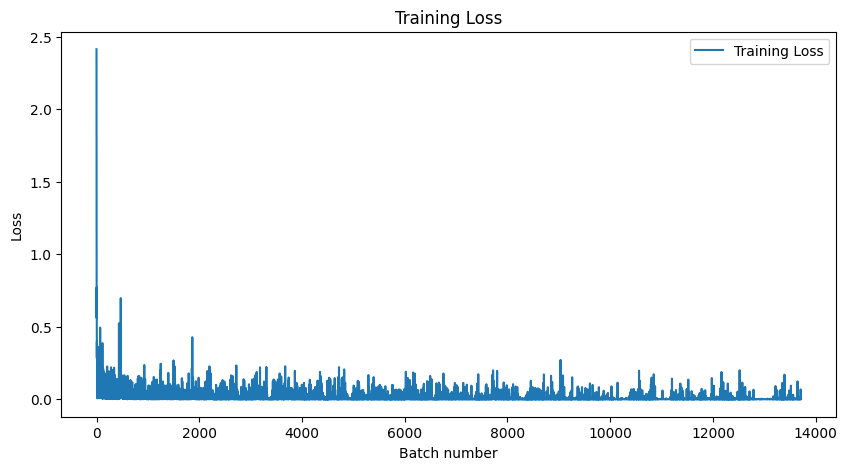

In [17]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test set: Average loss: 0.1296, Accuracy: 5043/10000 (50%)



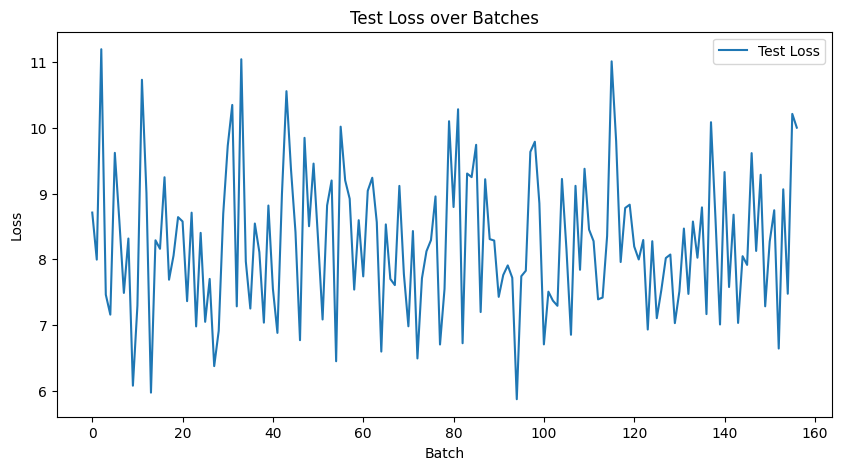

In [18]:
#Compute and Plot test loss
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate the model and plot the test loss
evaluate_and_plot_loss(model, device, test_loader)


. [30 pts] Use the first model to train a second model while fixing the feature extraction. Use
the entire training dataset this time. Report model performance on the full testing dataset.
Now train a third model and do not fix the feature extraction, and report its performance.
Compare these performances.



Ans -
Fine-Tuning More Layers: We will unfreeze a layer4 and fully connected layers of the model.
Layer-wise Unfreezing: We will implement a strategy to unfreeze layers progressively during training.
Learning Rate Scheduling: We will use a learning rate scheduler to adjust the learning rate during training.

The following code freeazes all the layers except full connected layers

In [33]:
full_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

from torch.optim.lr_scheduler import StepLR

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze some layers starting from the top
unfrozen_layers = ['layer4', 'fc']

for name, child in model.named_children():
    if name in unfrozen_layers:
        for param in child.parameters():
            param.requires_grad = True

# Replace the top layer for MNIST classification
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},  # Lower learning rate
    {'params': model.fc.parameters()}
], lr=1e-3)  # Higher learning rate for the classifier

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# Training function
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
         # Record the loss
        train_losses.append(loss.item())
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Evaluation function
def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


train_losses = []
# Training loop with scheduler step
for epoch in range(1, 11):
    train(model, device, full_train_loader, optimizer, epoch, train_losses)
    evaluate(model, device, test_loader)
    scheduler.step()  # Adjust the learning rate

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.475965
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.026744
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.007696
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.009460
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.003853
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.002306
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.001065
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.005043
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.001643
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.002138
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.002194
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.000350
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000096
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.001497
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.001543
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.000164
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000398
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.000410
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.001062
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000100
Train Epoch:

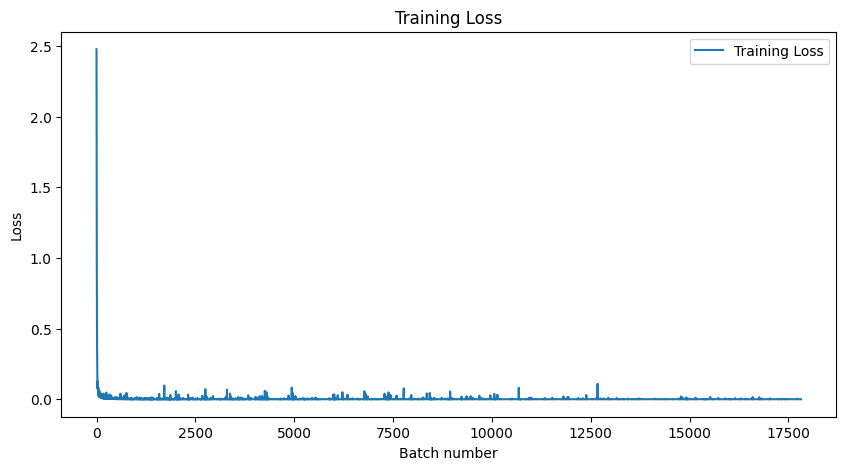

In [34]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test set: Average loss: 0.0006, Accuracy: 9943/10000 (99%)



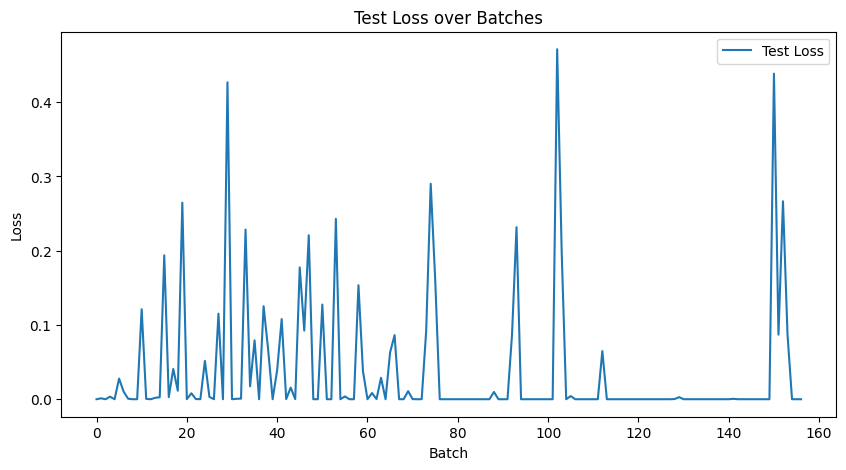

In [35]:
#Compute and Plot test loss
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate the model and plot the test loss
evaluate_and_plot_loss(model, device, test_loader)

Now train a third model and do not fix the feature extraction, and report its performance.
Compare these performances.

In [23]:
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




In [24]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# MNIST images are 1 channel (grayscale), ResNet expects 3 channels (RGB)
# We will modify the first convolutional layer to accept 1 channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training function
# Training function
# Training function that records the loss
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Record the loss
        train_losses.append(loss.item())

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
train_losses = []
for epoch in range(1, 30):
    train(model, device, train_loader, optimizer, epoch, train_losses)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.650568
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.547629
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.266674
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.604721
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.192484
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.187805
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.183283
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.222153
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.245097
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.161380
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.051034
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.093024
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.140372
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.076016
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.019367
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.243706
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.173893
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.033336
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.054879
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.167816
Train Epoch: 1 [12800/60000 (

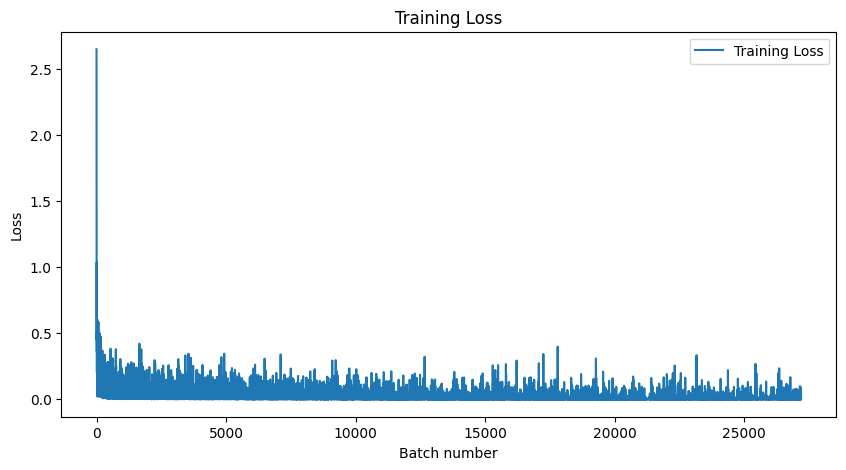

In [25]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test set: Average loss: 0.0005, Accuracy: 9930/10000 (99%)



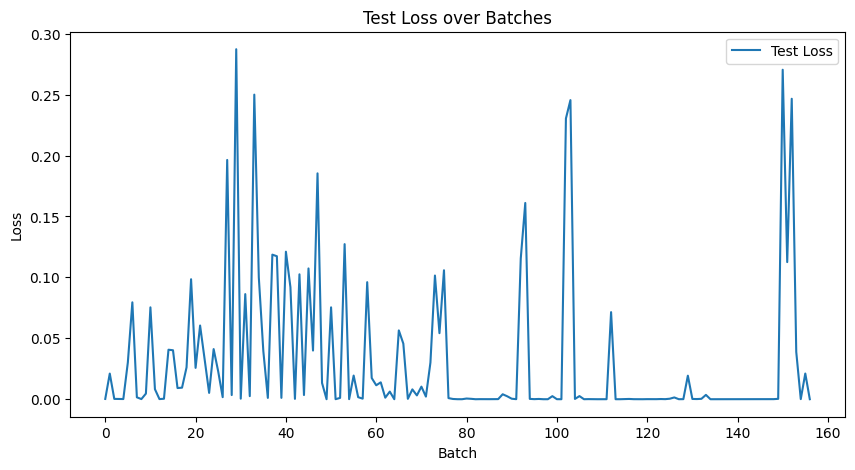

In [26]:
#Compute and Plot test loss
import matplotlib.pyplot as plt

# Evaluation function with loss plotting
def evaluate_and_plot_loss(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    losses = []

    with torch.no_grad():  # No gradients needed since we are only evaluating
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            losses.append(loss)  # Store the loss for this batch
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))

    # Plot the test loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate the model and plot the test loss
evaluate_and_plot_loss(model, device, test_loader)

4. [20 pts] Discuss the outcome you observed in (3.). Did the transfer learning work?

#Analysis
* The first model whioch was trained only on half training dataset performed poorly on test dataset with 50% acuracy
* The seocnd model which was trained on half training dataset but featrues retrained on remaining full training dataset, the test performance was improved to 99% with few iterations. Thats the power of transfer learning. We stand on the shoulders of giants. By using the pretrained weights , we reduced training time of the model
* The third model which was trained on complete train dataset showed a good performance on test dataset with 99% accuracy. The number of ietrations required are more as we are training full model on full dataset from the scratch.


